# Appendix G: LZSM Numerics



## Fig 16: effective vs RWA model

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import jv
import sys
sys.path.append('../common_scripts')
from floquet_system_st import floquet_system, SpatioTemporalNoise
from pathlib import Path
figures_path = Path().resolve().parent / 'figures'
# Parameters (similar to existing notebook)
det = 0
Vr = 2 * np.pi * 0.004
ddom = 2 * np.pi * 1e-3 * 0.4
Ldot = 20  # Dot size
x0 = 100   # Shuttling amplitude
v = 10     # Velocity
wc = 2 * np.pi * v / x0  # Conveyor frequency
dom = ddom * x0
wr = 1

# Period
T = 2 * np.pi / wc
print(f"Period T = {T:.2f}")

# Noise parameters
sigma = 0.02  # Noise amplitude
xc = 100    # Spatial correlation length

# Two cases to compare
tauc_quasistatic = 2000 # tauc >> T (quasistatic)
tauc_fast = 200                # tauc ~ T (fast noise)

print(f"\nCase 1: tauc = {tauc_quasistatic:.2f} (tauc/T = {tauc_quasistatic/T:.1f})")
print(f"Case 2: tauc = {tauc_fast:.2f} (tauc/T = {tauc_fast/T:.1f})")


Period T = 10.00

Case 1: tauc = 2000.00 (tauc/T = 200.0)
Case 2: tauc = 200.00 (tauc/T = 20.0)


In [2]:
# Generate spatio-temporal noise fields
# Domain size: need to cover trajectory and time range
# We'll simulate for t_total periods, so need domain >= t_total * T
t_total_sim = 50  # Expected simulation time in periods (will be set in simulation cell)
Lx = 3 * x0  # Spatial domain (covers -x0 to x0 with margin)
Lt = 1.5 * t_total_sim * T  # Time domain (150% of simulation time to avoid edge effects)

# Grid resolution
nx = 512  # Spatial grid points
nt = 2048  # Time grid points

print("Generating noise fields...")
print(f"Spatial domain: [-{Lx/2:.0f}, {Lx/2:.0f}], {nx} points")
print(f"Time domain: [0, {Lt:.2f}], {nt} points")
print(f"This covers {Lt/T:.1f} periods (simulation will use ~{t_total_sim} periods)")

# Case 1: Quasistatic (tauc >> T)
noise_quasistatic = SpatioTemporalNoise(
    nx=nx, nt=nt, xc=xc, tc=tauc_quasistatic,
    Lx=Lx, Lt=Lt, sigma=sigma, seed=42
)

# Case 2: Fast noise (tauc ~ T)
noise_fast = SpatioTemporalNoise(
    nx=nx, nt=nt, xc=xc, tc=tauc_fast,
    Lx=Lx, Lt=Lt, sigma=sigma, seed=42
)

print("Done!")


Generating noise fields...
Spatial domain: [-150, 150], 512 points
Time domain: [0, 750.00], 2048 points
This covers 75.0 periods (simulation will use ~50 periods)
Done!


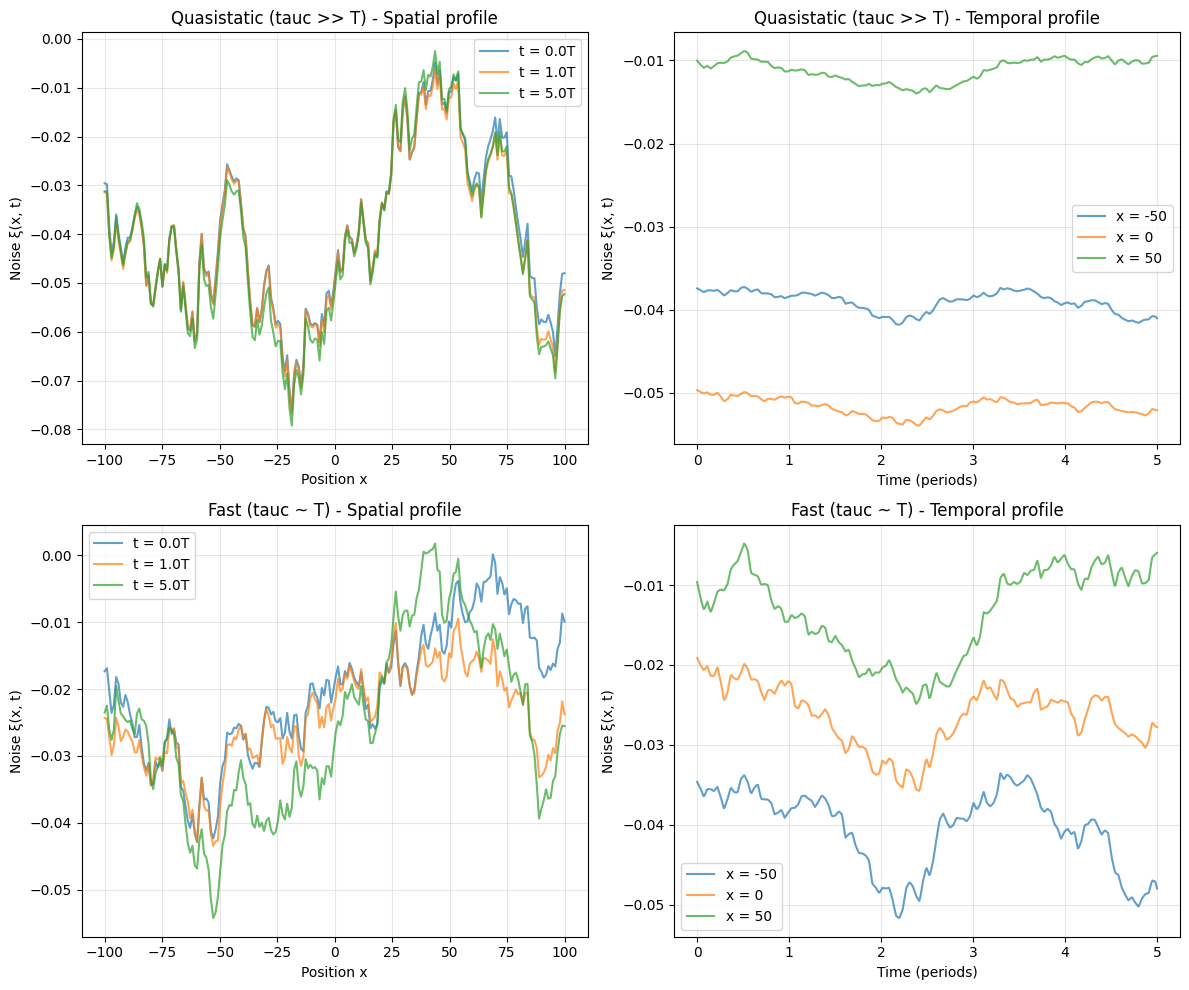

In [3]:
# Removed: diagnostic visualization
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Plot spatial slices at different times
times_slice = [0, T, 5*T]
x_plot = np.linspace(-x0, x0, 200)

for i, (noise, label) in enumerate([(noise_quasistatic, "Quasistatic (tauc >> T)"),
                                     (noise_fast, "Fast (tauc ~ T)")]):
    ax1, ax2 = axes[i, 0], axes[i, 1]
    
    # Spatial slice at different times
    for t in times_slice:
        xi_vals = noise.get_xi(x_plot, t)
        ax1.plot(x_plot, xi_vals, label=f't = {t/T:.1f}T', alpha=0.7)
    ax1.set_xlabel('Position x')
    ax1.set_ylabel('Noise ξ(x, t)')
    ax1.set_title(f'{label} - Spatial profile')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Temporal slice at different positions
    t_plot = np.linspace(0, 5*T, 500)
    for x in [-x0/2, 0, x0/2]:
        xi_vals = noise.get_xi(x, t_plot)
        ax2.plot(t_plot/T, xi_vals, label=f'x = {x:.0f}', alpha=0.7)
    ax2.set_xlabel('Time (periods)')
    ax2.set_ylabel('Noise ξ(x, t)')
    ax2.set_title(f'{label} - Temporal profile')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [4]:
# Run simulations for both cases
from tqdm import tqdm

t_total = 200  # Total time in periods
dt = 0.05     # Time step in periods
Ntraj = 200     # Number of trajectories

# Check if we need to regenerate noise fields with larger time domain
if Lt < 1.2 * t_total * T:
    print(f"⚠️  Time domain too small! Regenerating noise fields...")
    Lt_new = 1.5 * t_total * T
    print(f"   Old domain: [0, {Lt:.1f}]")
    print(f"   New domain: [0, {Lt_new:.1f}] (covers {t_total*T:.1f} simulation time)")
    
    # Regenerate with larger domain
    noise_quasistatic = SpatioTemporalNoise(
        nx=nx, nt=nt, xc=xc, tc=tauc_quasistatic,
        Lx=Lx, Lt=Lt_new, sigma=sigma, seed=42
    )
    
    noise_fast = SpatioTemporalNoise(
        nx=nx, nt=nt, xc=xc, tc=tauc_fast,
        Lx=Lx, Lt=Lt_new, sigma=sigma, seed=42
    )
    Lt = Lt_new
    print("   ✓ Noise fields regenerated\n")

results = {}

for case_name, noise in [("quasistatic", noise_quasistatic), 
                          ("fast", noise_fast)]:
    print(f"\nRunning {case_name} case...")
    
    # Create system
    system = floquet_system(
        det=det, Vr=Vr, wc=wc, dom=dom, wr=wr,
        Ldot=Ldot, x0=x0, phi0=0,
        spatio_temporal_noise=noise
    )
    
    # Run RWA model
    print("  RWA model...")
    times_rwa, probs_rwa, xis_rwa = system.avg_trajectories(
        t_total, dt, Ntraj, model='RWA'
    )
    
    # Run effective model
    print("  Effective model...")
    times_eff, probs_eff, xis_eff = system.avg_trajectories(
        t_total, dt, Ntraj, model='effective'
    )
    
    results[case_name] = {
        'times_rwa': times_rwa,
        'probs_rwa': probs_rwa,
        'times_eff': times_eff,
        'probs_eff': probs_eff,
        'xis_rwa': xis_rwa,
        'xis_eff': xis_eff
    }
    
print("\nDone!")


⚠️  Time domain too small! Regenerating noise fields...
   Old domain: [0, 750.0]
   New domain: [0, 3000.0] (covers 2000.0 simulation time)
   ✓ Noise fields regenerated


Running quasistatic case...
  RWA model...
  Effective model...


Process SpawnPoolWorker-9:
Process SpawnPoolWorker-11:
Process SpawnPoolWorker-16:
Traceback (most recent call last):
Process SpawnPoolWorker-15:
Traceback (most recent call last):
Process SpawnPoolWorker-10:
Process SpawnPoolWorker-13:
  File "/opt/anaconda3/lib/python3.12/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/opt/anaconda3/lib/python3.12/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/anaconda3/lib/python3.12/multiprocessing/pool.py", line 125, in worker
    result = (True, func(*args, **kwds))
                    ^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.12/multiprocessing/pool.py", line 48, in mapstar
    return list(map(*args))
           ^^^^^^^^^^^^^^^^
  File "/Users/krzywdaja/Documents/spatial-correlations-conveyor/data_analysis/protection_code_repo/get_processed_data/../common_scripts/floquet_system_st.py", line 427, in _run_single_trajectory
    return self.get_trajec

KeyboardInterrupt: 

KeyError: 'quasistatic'

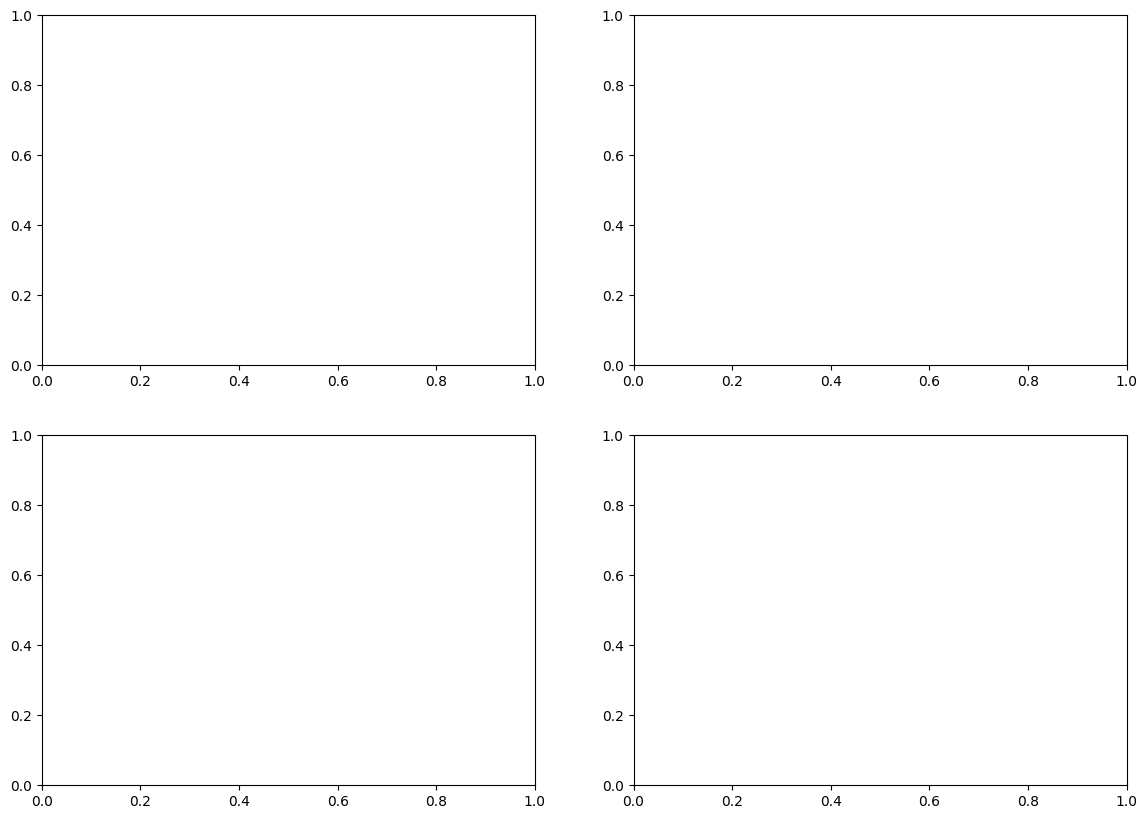

In [5]:
# Removed: diagnostic plot
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

for idx, (case_name, case_label) in enumerate([("quasistatic", "Quasistatic (tauc >> T)"),
                                                ("fast", "Fast (tauc ~ T)")]):
    data = results[case_name]
    
    # Left column: Probability evolution
    ax = axes[idx, 0]
    ax.plot(data['times_rwa']/T, data['probs_rwa'][:, 1], 
            label='RWA', linewidth=2, alpha=0.8)
    ax.plot(data['times_eff']/T, data['probs_eff'][:, 1], 
            label='Effective', linewidth=2, alpha=0.8, linestyle='--')
    ax.set_xlabel('Time (periods)')
    ax.set_ylabel('Probability |1⟩')
    ax.set_title(f'{case_label} - Probability')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Right column: Difference between models
    ax = axes[idx, 1]
    # Interpolate to same time grid for comparison
    times_common = data['times_rwa']
    probs_eff_interp = np.interp(times_common, data['times_eff'], data['probs_eff'][:, 1])
    diff = data['probs_rwa'][:, 1] - probs_eff_interp
    ax.plot(times_common/T, diff, linewidth=2, color='red', alpha=0.8)
    ax.axhline(0, color='black', linestyle=':', alpha=0.5)
    ax.set_xlabel('Time (periods)')
    ax.set_ylabel('Difference (RWA - Effective)')
    ax.set_title(f'{case_label} - Model Difference')
    ax.grid(True, alpha=0.3)
    ax.set_ylim(0,1)



plt.tight_layout()
plt.show()


In [16]:
# Sweep over x0 and create colorplots
from tqdm import tqdm

# Parameters for sweep
x0_min, x0_max = 30, 220
n_x0 = 35
x0s = np.linspace(x0_min, x0_max, n_x0)

# Simulation parameters - constant absolute time
tmax = 1500  # Total time in absolute units (not periods)
dt = 0.2     # Time step in absolute units
Ntraj = 200   # Number of trajectories

# Storage for results: [case][model][x0_index] -> (times, probs)
results_sweep = {
    'quasistatic': {'RWA': [], 'effective': []},
    'fast': {'RWA': [], 'effective': []},
    'clean': {'RWA': [], 'effective': []}
}

print("Running x0 sweep...")
print(f"x0 values: {x0s}")

for x0 in tqdm(x0s):
    # Update wc based on x0 (keeping v constant)
    wc = 2 * np.pi * v / x0
    dom = ddom * x0
    T = 2 * np.pi / wc  # Period for current x0
    
    # Convert absolute time to periods for this x0
    t_T = tmax / T  # Total time in periods
    dt_T = dt / T   # Time step in periods
    
    # Update spatial domain if needed
    Lx_new = 3 * x0
    if Lx_new > Lx:
        Lx = Lx_new
        # Regenerate noise fields with larger spatial domain
        noise_quasistatic = SpatioTemporalNoise(
            nx=nx, nt=nt, xc=xc, tc=tauc_quasistatic,
            Lx=Lx, Lt=Lt, sigma=sigma, seed=56
        )
        noise_fast = SpatioTemporalNoise(
            nx=nx, nt=nt, xc=xc, tc=tauc_fast,
            Lx=Lx, Lt=Lt, sigma=sigma, seed=56
        )
    
    # Update time domain if needed (to cover tmax)
    if tmax > Lt:
        Lt = 1.5 * tmax  # 150% margin
        # Regenerate noise fields with larger time domain
        noise_quasistatic = SpatioTemporalNoise(
            nx=nx, nt=nt, xc=xc, tc=tauc_quasistatic,
            Lx=Lx, Lt=Lt, sigma=sigma, seed=56
        )
        noise_fast = SpatioTemporalNoise(
            nx=nx, nt=nt, xc=xc, tc=tauc_fast,
            Lx=Lx, Lt=Lt, sigma=sigma, seed=56
        )
    
    # Run for both noise cases
    for case_name, noise in [("quasistatic", noise_quasistatic), 
                              ("fast", noise_fast)]:
        # Create system with current x0
        system = floquet_system(
            det=det, Vr=Vr, wc=wc, dom=dom, wr=wr,
            Ldot=Ldot, x0=x0, phi0=0,
            spatio_temporal_noise=noise
        )
        
        # Run RWA model (t_T and dt_T are in periods, but result is in absolute time)
        times_rwa, probs_rwa, _ = system.avg_trajectories(
            t_T, dt_T, Ntraj, model='RWA'
        )
        results_sweep[case_name]['RWA'].append((times_rwa, probs_rwa))
        
        # Run effective model
        times_eff, probs_eff, _ = system.avg_trajectories(
            t_T, dt_T, Ntraj, model='effective'
        )
        results_sweep[case_name]['effective'].append((times_eff, probs_eff))
    
    # Run clean case (no noise) - single trajectory is enough
    system_clean = floquet_system(
        det=det, Vr=Vr, wc=wc, dom=dom, wr=wr,
        Ldot=Ldot, x0=x0, phi0=0,
        spatio_temporal_noise=None  # No noise
    )
    
    # Run RWA model (clean)
    times_rwa_clean, probs_rwa_clean, _ = system_clean.avg_trajectories(
        t_T, dt_T, 1, model='RWA'  # Single trajectory
    )
    results_sweep['clean']['RWA'].append((times_rwa_clean, probs_rwa_clean))
    
    # Run effective model (clean)
    times_eff_clean, probs_eff_clean, _ = system_clean.avg_trajectories(
        t_T, dt_T, 1, model='effective'  # Single trajectory
    )
    results_sweep['clean']['effective'].append((times_eff_clean, probs_eff_clean))

print("\nDone!")


Running x0 sweep...
x0 values: [ 30.          35.58823529  41.17647059  46.76470588  52.35294118
  57.94117647  63.52941176  69.11764706  74.70588235  80.29411765
  85.88235294  91.47058824  97.05882353 102.64705882 108.23529412
 113.82352941 119.41176471 125.         130.58823529 136.17647059
 141.76470588 147.35294118 152.94117647 158.52941176 164.11764706
 169.70588235 175.29411765 180.88235294 186.47058824 192.05882353
 197.64705882 203.23529412 208.82352941 214.41176471 220.        ]


 57%|█████▋    | 20/35 [44:28<31:23, 125.54s/it]  python(98595) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(98594) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(98596) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(98597) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(98598) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(98599) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(98600) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(98601) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(98613) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(98614) MallocStackLogging: can't turn off malloc stack loggin


Done!


<>:65: SyntaxWarning: invalid escape sequence '\m'
<>:65: SyntaxWarning: invalid escape sequence '\m'
/var/folders/wj/x78z9z710q7csr068fhd10bxk7mx3x/T/ipykernel_92225/4250517303.py:65: SyntaxWarning: invalid escape sequence '\m'
  ax.set_ylabel('Time ($\mu$s)')


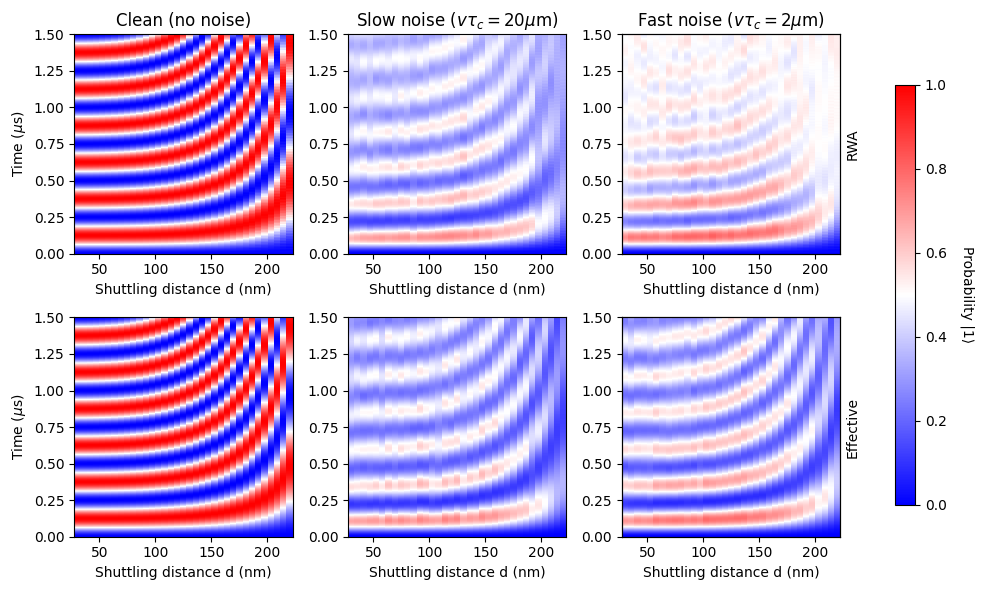

In [18]:
# Create 2x3 colorplots (2 rows: RWA/Effective, 3 columns: Clean/Quasistatic/Fast)
fig, axes = plt.subplots(2, 3, figsize=(10, 6))

# First, find a common time grid (use the longest time range)
all_times = []
for case_name in ['clean','quasistatic', 'fast']:
    for model_name in ['RWA', 'effective']:
        for times, _ in results_sweep[case_name][model_name]:
            all_times.append(times)

# Use the maximum time range and create a common grid
t_min = min(t[0] for t in all_times)
t_max = max(t[-1] for t in all_times)
# Use a reasonable number of points (e.g., from the longest trajectory)
n_times_common = max(len(t) for t in all_times)
times_common = np.linspace(t_min, t_max, n_times_common)

# Prepare data for colorplots
# Cases: clean (col 0), quasistatic (col 1), fast (col 2)
cases = [
    ("clean", r"Clean (no noise)"),
    ("quasistatic", r"Slow noise ($v\tau_c = 20\mu$m)"),
    ("fast", r"Fast noise ($v\tau_c = 2\mu$m)")
]

# Models: RWA (row 0), effective (row 1)
models = [
    ("RWA", "RWA"),
    ("effective", "Effective"),
]

# Store one image object for the colorbar
im_for_cbar = None

for idx_model, (model_name, model_label) in enumerate(models):
    for idx_case, (case_name, case_label) in enumerate(cases):
        ax = axes[idx_model, idx_case]
        
        if idx_model == 0:
            ax.set_title(case_label, fontsize = 12)

        # Collect probability data for all x0 values, interpolated to common time grid
        prob_data = []  # Will be shape (n_x0, n_times)
        
        for i, x0 in enumerate(x0s):
            times, probs = results_sweep[case_name][model_name][i]
            # Extract |1⟩ probability
            prob_1 = probs[:, 1]
            
            # Interpolate to common time grid
            prob_1_interp = np.interp(times_common, times, prob_1)
            prob_data.append(prob_1_interp)
        
        prob_data = np.array(prob_data)  # Shape: (n_x0, n_times)
        
        # Create colorplot
        im = ax.pcolormesh(x0s, times_common/1e3, prob_data.T, cmap="bwr", vmin=0, vmax=1, rasterized=True)
        
        # Store first image for colorbar
        if im_for_cbar is None:
            im_for_cbar = im
        
        ax.set_xlabel('Shuttling distance d (nm)')
        if idx_case == 0:  # Only label y-axis for first column
            ax.set_ylabel('Time ($\mu$s)')
        
        if idx_case == 2:
            bx = ax.twinx()
            bx.set_yticks([])
            bx.set_ylabel(model_label)

# Adjust layout first to make room for colorbar on the right
plt.tight_layout(rect=[0, 0, 0.88, 1])

# Create a dedicated axes for the colorbar on the right side
cbar_ax = fig.add_axes([0.90, 0.15, 0.02, 0.7])  # [left, bottom, width, height] in figure coordinates

# Add common colorbar on the right side of the entire figure
cbar = fig.colorbar(im_for_cbar, cax=cbar_ax, orientation='vertical')
cbar.set_label('Probability |1⟩', rotation=270, labelpad=20)

plt.savefig(f"{figures_path}/app_fig16_LZSM_rwa_ham.pdf")



## Fig 17: $\Omega_R$ and $\xi_T$

/var/folders/wj/x78z9z710q7csr068fhd10bxk7mx3x/T/ipykernel_85073/2436629129.py:50: RuntimeWarning: divide by zero encountered in divide
  ws = 2 * np.pi * v / ds / 2 * 1e9


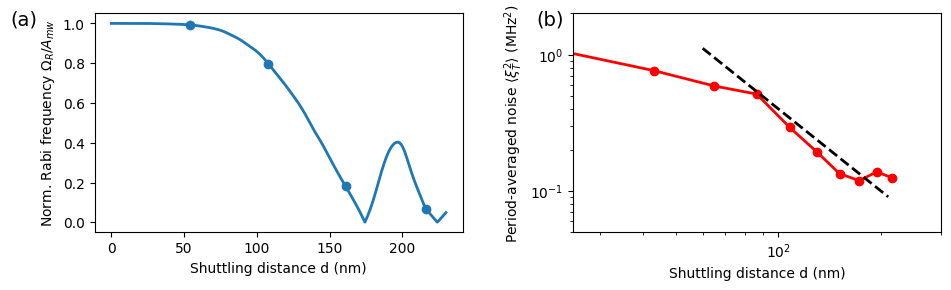

In [6]:
# Recreate tradeoff plot from Plot_fig2_fig3_fig4.ipynb
import pickle
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from scipy.special import j0

# Load frequency data
freq_file = Path('../processed_data/fig23/freq_compare_data_for_plot.npz')
freq_data = np.load(freq_file)

xl = freq_data["t_fine_low"]
xh = freq_data["x_highfield_raw"]
fl = freq_data["freq_low_for_plot"]
fh = freq_data["y_highfield_raw"]

# Load shuttling data
field = "high"  # Use high field data
shuttling_file = Path(f'../processed_data/fig4/shuttling_{field}.pkl')
with open(shuttling_file, 'rb') as f:
    shuttling_data = pickle.load(f)



# Extract Ramsey data
T2shuttle = [shuttling_data["CPMG-3"][m]["Decay time"] * 1e-9 for m in range(len(shuttling_data["Echo"]))]  # in seconds
alpha_shuttle = [shuttling_data["Echo"][m]["Exponent"] for m in range(len(shuttling_data["Echo"]))]
distances = [shuttling_data["Echo"][m]["dx"] for m in range(len(shuttling_data["Echo"]))]  # in nm



T2shuttle = np.array(T2shuttle)
alpha_shuttle = np.array(alpha_shuttle)
distances = np.array(distances)
# Calculate period and chi
v = 10.8  # velocity in m/s (or nm/ns?)
Ts = 2 * distances / v* 1e-9  # in seconds (assuming v=10 nm/ns = 10 m/s)
chis = (Ts / T2shuttle) ** 1  # 

# Create the plot
fun_f = lambda d: np.interp(d, xh, fh[::-1])

ds = np.linspace(0, 230, 501)
dbz = lambda x: fh[-1] - fun_f(x)
v = 10.8 #m/s

ds0 = np.array([54, 108, 161, 216])    # Positions of the shuttling data
ws0 = 2 * np.pi * v / ds0 / 2 * 1e9    # shittling frequencies at the shuttling positions
dw = dbz(ds) * 2 * np.pi * 1e6
ws = 2 * np.pi * v / ds / 2 * 1e9

fig, ax = plt.subplots(1, 2, figsize=(9.5, 3))
plt.subplots_adjust(wspace=0.3)

# Left panel: Normalized Rabi frequency
ax[0].plot(ds, np.abs(j0(dw / ws / 2)), lw=2)
ax[0].scatter(ds0, np.abs(j0(dbz(ds0) * 2 * np.pi * 1e6 / ws0 / 2)))
ax[0].set_xlabel("Shuttling distance d (nm)")
ax[0].set_ylabel(r"Norm. Rabi frequency $\Omega_R/A_{mw}$")
ax[1].set_ylim(0.05,2)
# Right panel: Period-average noise
ax[1].plot(distances, chis / Ts**2 / 1e12/2/2/np.pi, "o-", lw=2, color="red")
ax[1].set_xlabel("Shuttling distance d (nm)")
ax[1].set_ylabel(r"Period-averaged noise $\langle \xi_T^2 \rangle$ (MHz$^2$)")
#ax[1].set_ylim(top = 17*1e-1)
ax[0].text(-0.23, 0.95, '(a)', fontsize=14, transform=ax[0].transAxes)
ax[1].text(-0.1, 0.95, '(b)', fontsize=14, transform=ax[1].transAxes)
ax[1].set_yscale("log")
ax[1].set_xscale("log")
ax[1].set_xlim(25,300)

x = np.linspace(60,210,100)
ax[1].plot(x, 4*1e3/x**2, "--k", lw=2)
plt.tight_layout()
plt.subplots_adjust(wspace=0.3)
plt.savefig(f"{figures_path}/app_tradeoff.pdf", bbox_inches='tight', dpi=300)
plt.show()

